In [1]:
import pandas as pd
import numpy as np

In [2]:
Prices_GER_weekly_date_range_1= pd.read_csv('../data/Prices_GER_weekly_date_range_1.csv', encoding='utf-8',thousands=',')
Prices_GER_monthly_date_range_1= pd.read_csv('../data/Prices_GER_monthly_date_range_1.csv', encoding='utf-8',thousands=',')
Prices_GER_weekly_date_range_2= pd.read_csv('../data/Prices_GER_weekly_date_range_2.csv', encoding='utf-8',thousands=',')
Prices_GER_monthly_date_range_2= pd.read_csv('../data/Prices_GER_monthly_date_range_2.csv', encoding='utf-8',thousands=',')

In [3]:
Prices_GER_weekly_date_range_1['Start'] = pd.to_datetime(Prices_GER_weekly_date_range_1['Start'])
Prices_GER_weekly_date_range_1 = Prices_GER_weekly_date_range_1.set_index('Start')

Prices_GER_monthly_date_range_1['Start'] = pd.to_datetime(Prices_GER_monthly_date_range_1['Start'])
Prices_GER_monthly_date_range_1 = Prices_GER_monthly_date_range_1.set_index('Start')


Prices_GER_weekly_date_range_2['Start'] = pd.to_datetime(Prices_GER_weekly_date_range_2['Start'])
Prices_GER_weekly_date_range_2 = Prices_GER_weekly_date_range_2.set_index('Start')

Prices_GER_monthly_date_range_2['Start'] = pd.to_datetime(Prices_GER_monthly_date_range_2['Start'])
Prices_GER_monthly_date_range_2 = Prices_GER_monthly_date_range_2.set_index('Start')



In [4]:
Prices_GER_weekly_date_range_1['Seasonal_difference'] = Prices_GER_weekly_date_range_1['Germany_Luxembourg'].diff(52)
Prices_GER_weekly_date_range_1['Seasonal_difference_adjusted'] = Prices_GER_weekly_date_range_1['Germany_Luxembourg_adjusted'].diff(52)

In [5]:
Prices_GER_monthly_date_range_1['Seasonal_difference_adjusted'] = Prices_GER_monthly_date_range_1['Germany_Luxembourg_adjusted'].diff(12)

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# plt.rcParams.update({'font.size': 13})

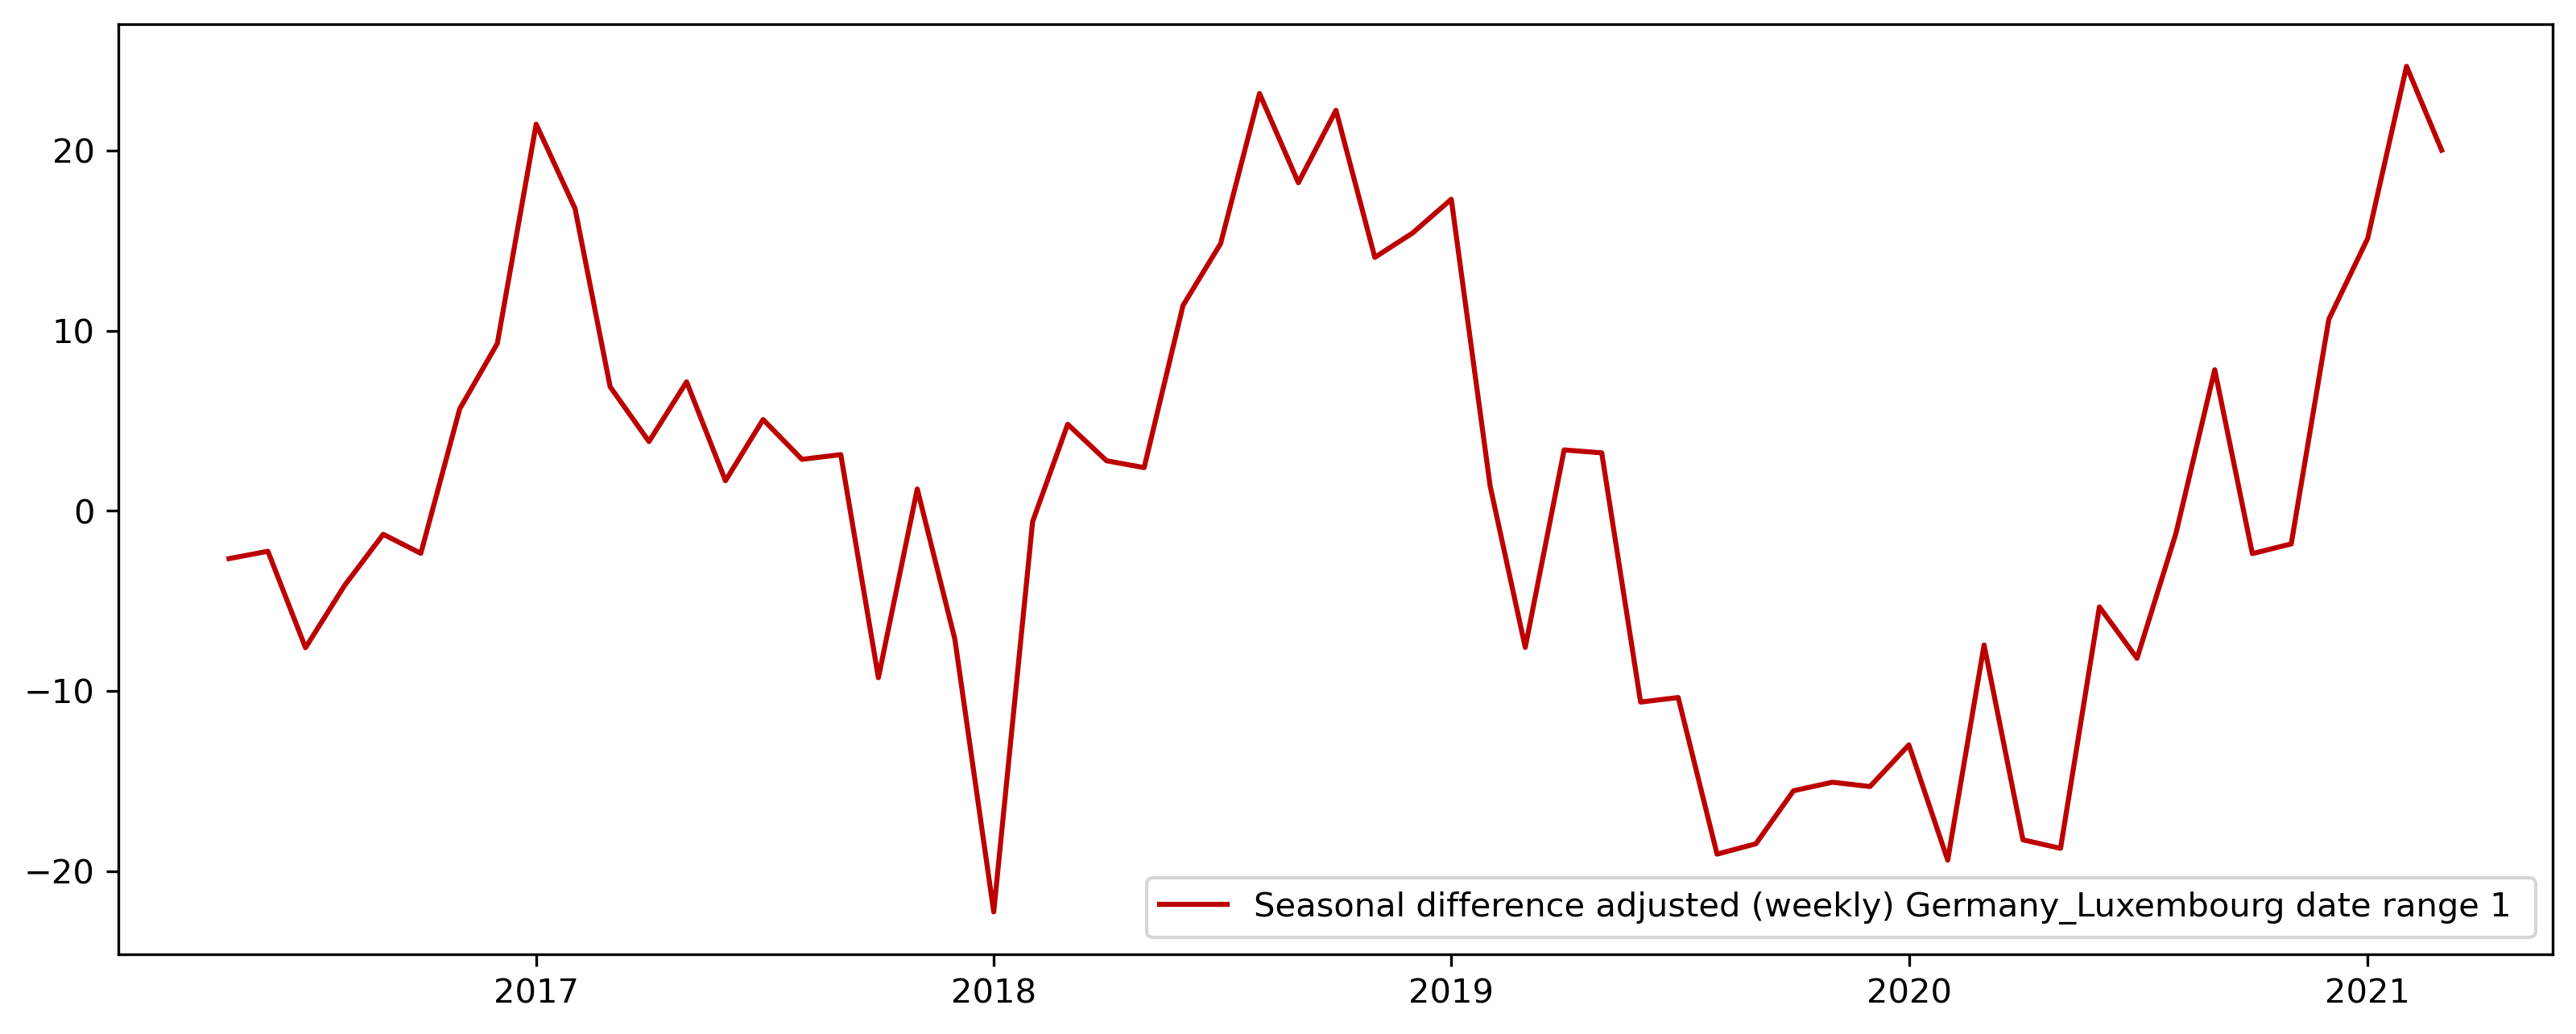

In [7]:
plt.figure(figsize= (13,5), dpi = 300)

plt.plot(Prices_GER_monthly_date_range_1['Seasonal_difference_adjusted'], label = 'Seasonal difference adjusted (weekly) Germany_Luxembourg date range 1 ', color = '#bc0000')
plt.legend()
plt.show()

In [8]:
train = Prices_GER_weekly_date_range_1[['Seasonal_difference_adjusted']].loc[Prices_GER_weekly_date_range_1.index <= "2020-04-01"].dropna()
test = Prices_GER_weekly_date_range_1[['Seasonal_difference_adjusted']].loc[Prices_GER_weekly_date_range_1.index > "2020-04-01"]

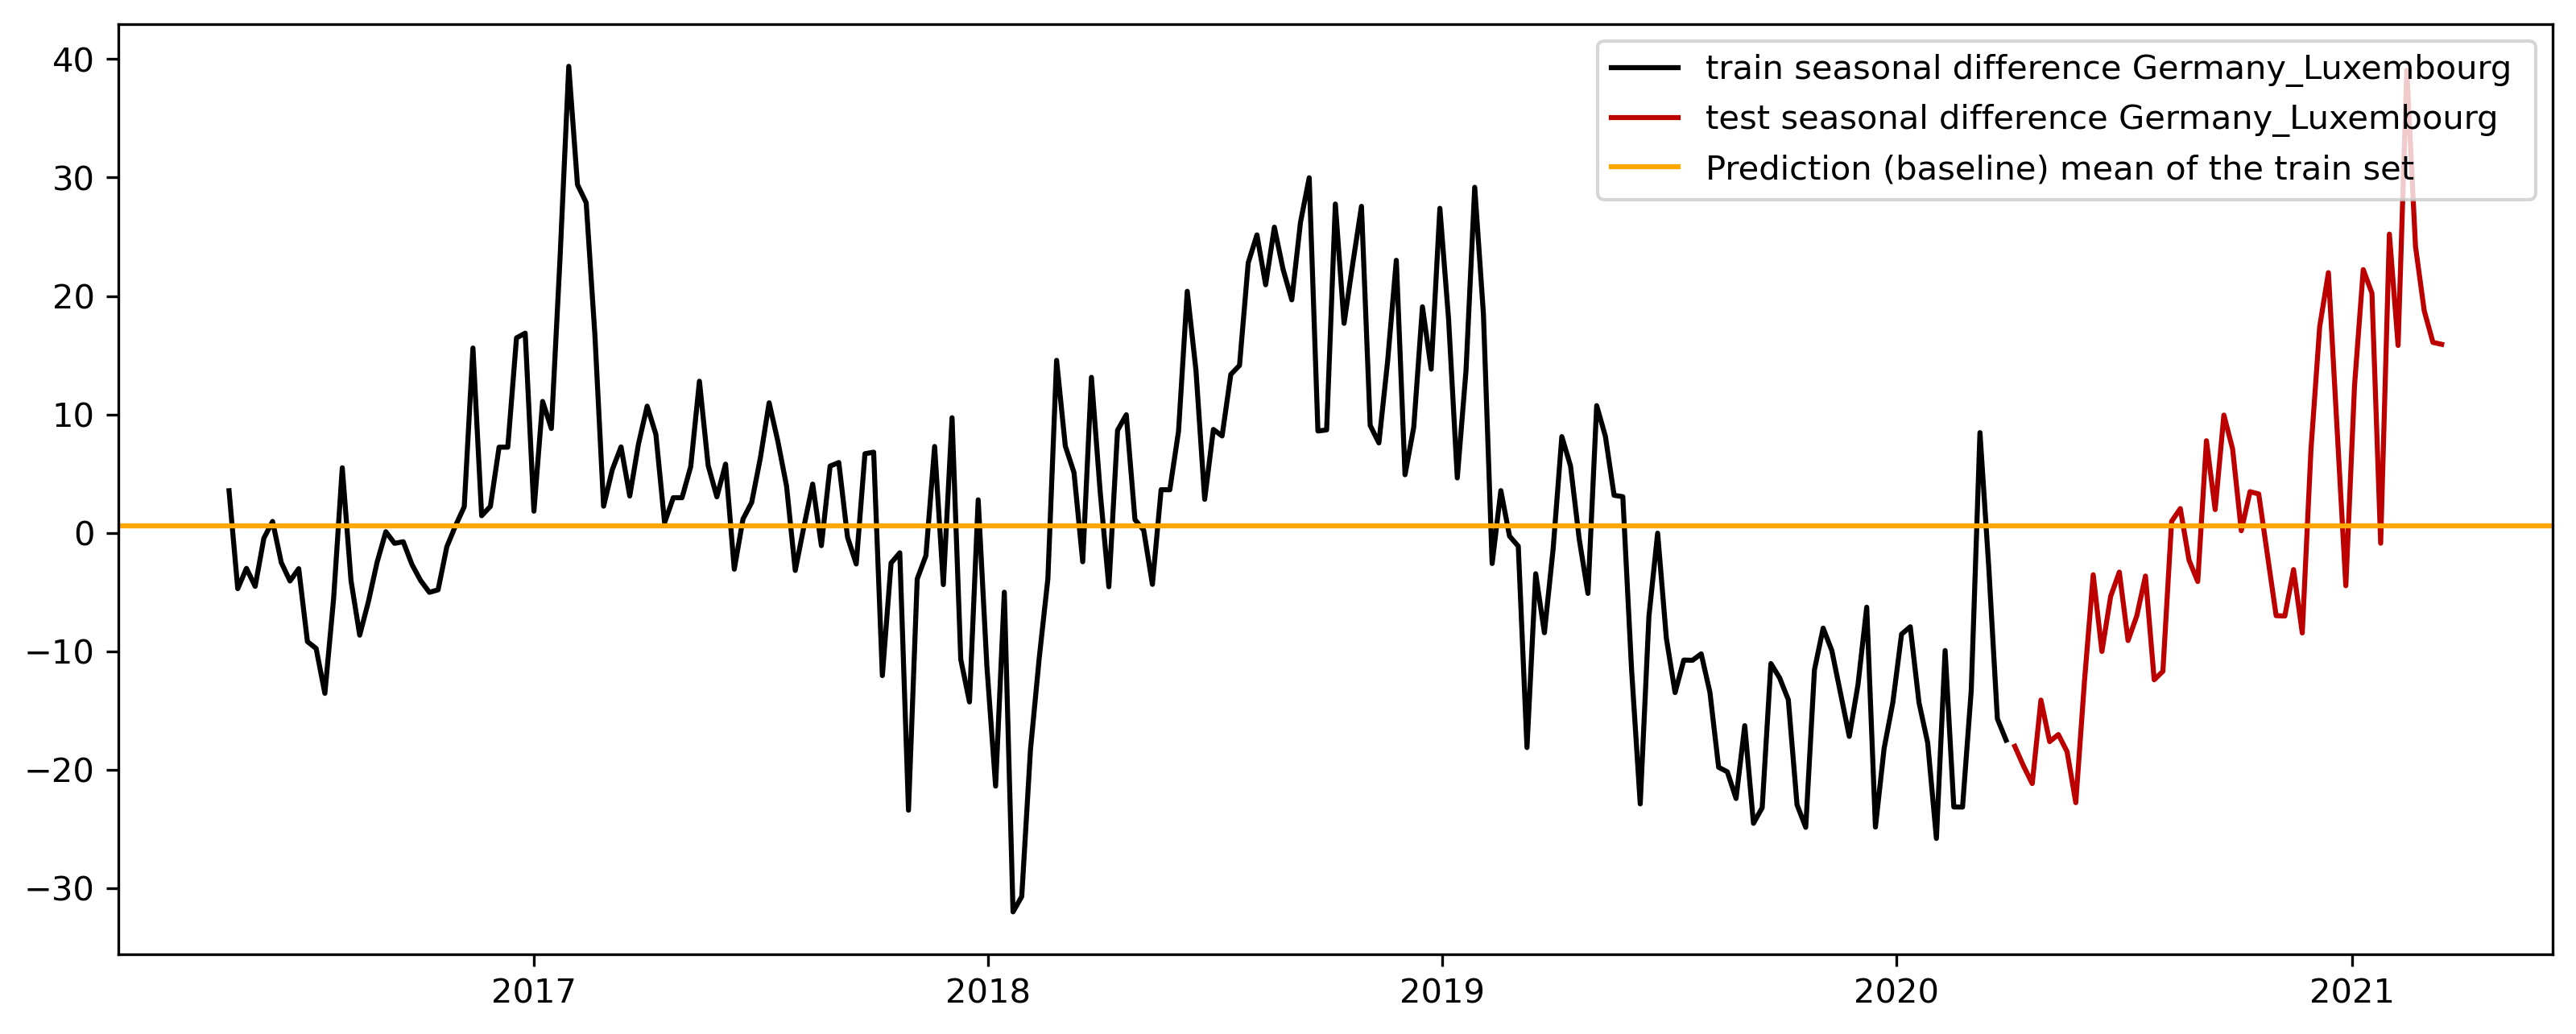

In [9]:
plt.figure(figsize= (13,5), dpi = 300)


plt.plot(train['Seasonal_difference_adjusted'], label = 'train seasonal difference Germany_Luxembourg ', color = '#000000')
plt.plot(test['Seasonal_difference_adjusted'], label = 'test seasonal difference Germany_Luxembourg', color = '#bc0000')
plt.axhline(y= train['Seasonal_difference_adjusted'].mean(),xmax=0, xmin=100, label = 'Prediction (baseline) mean of the train set', color= '#ffa600')

plt.legend()
plt.show()

In [10]:
train_series = pd.Series(train['Seasonal_difference_adjusted'].values, index=train.index, name='Seasonal_difference_adjusted')
test_series =  pd.Series(test['Seasonal_difference_adjusted'].values, index=test.index, name='Seasonal_difference_adjusted')

full_index = full_index = pd.concat([train_series, test_series]).index
base_line = np.full(full_index.shape, np.mean(train_series))

predictions = pd.Series(data=base_line, index=full_index)

In [11]:
def mean_absolute_percentage_error(true_values, predicted_values):
    """
    Calculate the mean absolute percentage error. 
    Find the prediction error and devide by the true value, then average.
    """
    
    error = true_values - predicted_values
    error.dropna()
    absolute_percentage_error = np.abs(error/true_values)
    mape = absolute_percentage_error.mean() * 100
    
    return mape



In [12]:
train_mape = mean_absolute_percentage_error(train_series, predictions[train_series.index])
test_mape = mean_absolute_percentage_error(test_series, predictions[test_series.index])

print(f"Train MAPE on the difference: {round(train_mape, 2)}%")
print(f"Test MAPE on the difference: {round(test_mape, 2)}%")

Train MAPE on the difference: 117.94%
Test MAPE on the difference: 104.6%


Autocorrelation

In [13]:
Prices_GER_weekly_date_range_1['Seasonal_difference_adjusted'] = Prices_GER_weekly_date_range_1['Germany_Luxembourg_adjusted'].diff(52)

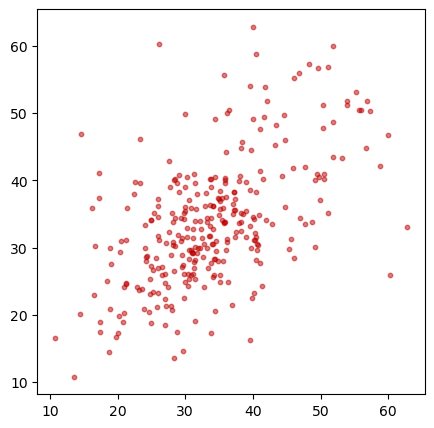

In [14]:
plt.figure(figsize=(5,5), dpi=100)

plt.scatter(x=Prices_GER_weekly_date_range_1['Germany_Luxembourg_adjusted'],y=Prices_GER_weekly_date_range_1['Germany_Luxembourg_adjusted'].shift(4), color='#bc0000', s= 10, alpha=0.5)

plt.show()

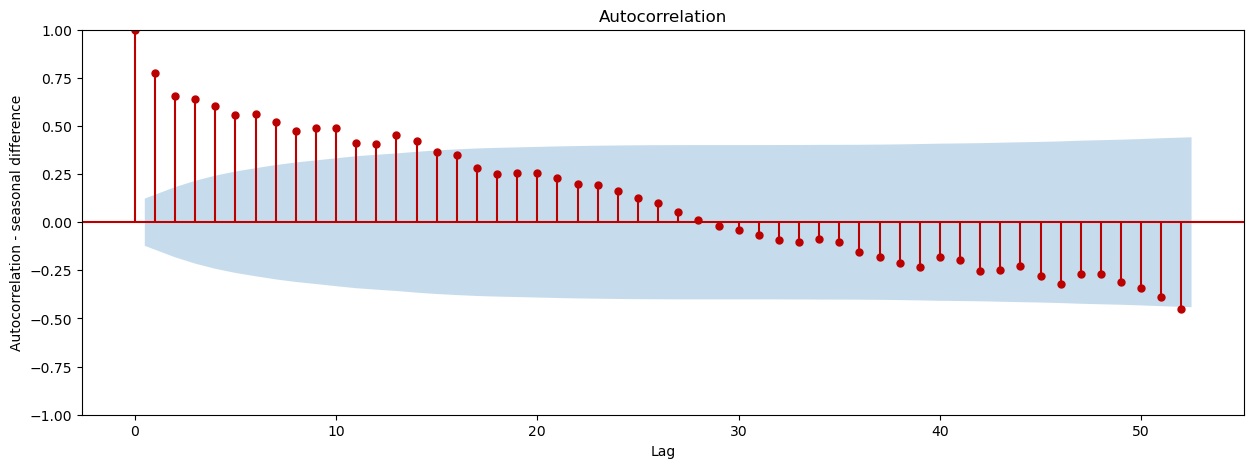

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(15, 5))

# put the acf plot on the current axis
plot_acf(Prices_GER_weekly_date_range_1['Seasonal_difference_adjusted'].dropna(), lags=52, ax=plt.gca(), color= '#bc0000', vlines_kwargs={"colors": '#bc0000'})
plt.xlabel('Lag')
plt.ylabel('Autocorrelation - seasonal difference')
plt.show()

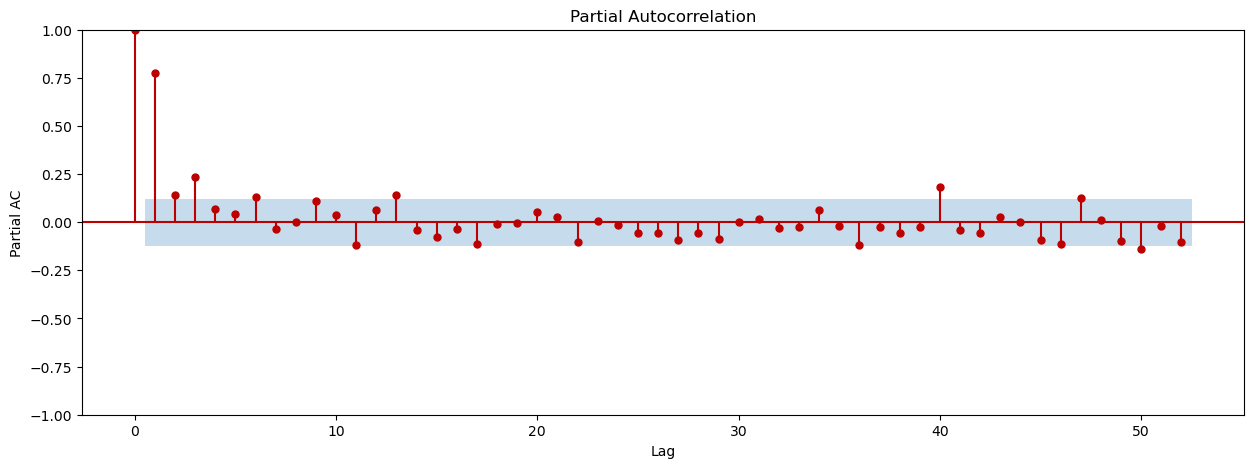

In [16]:
plt.figure(figsize=(15, 5))
plot_pacf(Prices_GER_weekly_date_range_1['Seasonal_difference_adjusted'].dropna(), lags=52, ax=plt.gca(), method='ywm', color= '#bc0000', vlines_kwargs={"colors": '#bc0000'})
plt.xlabel('Lag')
plt.ylabel('Partial AC')
plt.show()

In [17]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

p_param = 4

model = SARIMAX(train, order=(p_param, 0, 0), trend="c")
model_fit = model.fit(disp=0)

print(model_fit.summary())

                                    SARIMAX Results                                     
Dep. Variable:     Seasonal_difference_adjusted   No. Observations:                  205
Model:                         SARIMAX(4, 0, 0)   Log Likelihood                -718.143
Date:                          Fri, 21 Jun 2024   AIC                           1448.286
Time:                                  00:23:51   BIC                           1468.224
Sample:                              05-01-2016   HQIC                          1456.351
                                   - 03-29-2020                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.572      0.001      0.999      -1.121       1.122
ar.L1          0.6415      0.072      8.935      0.

c:\Users\BMidd\.conda\envs\capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\BMidd\.conda\envs\capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


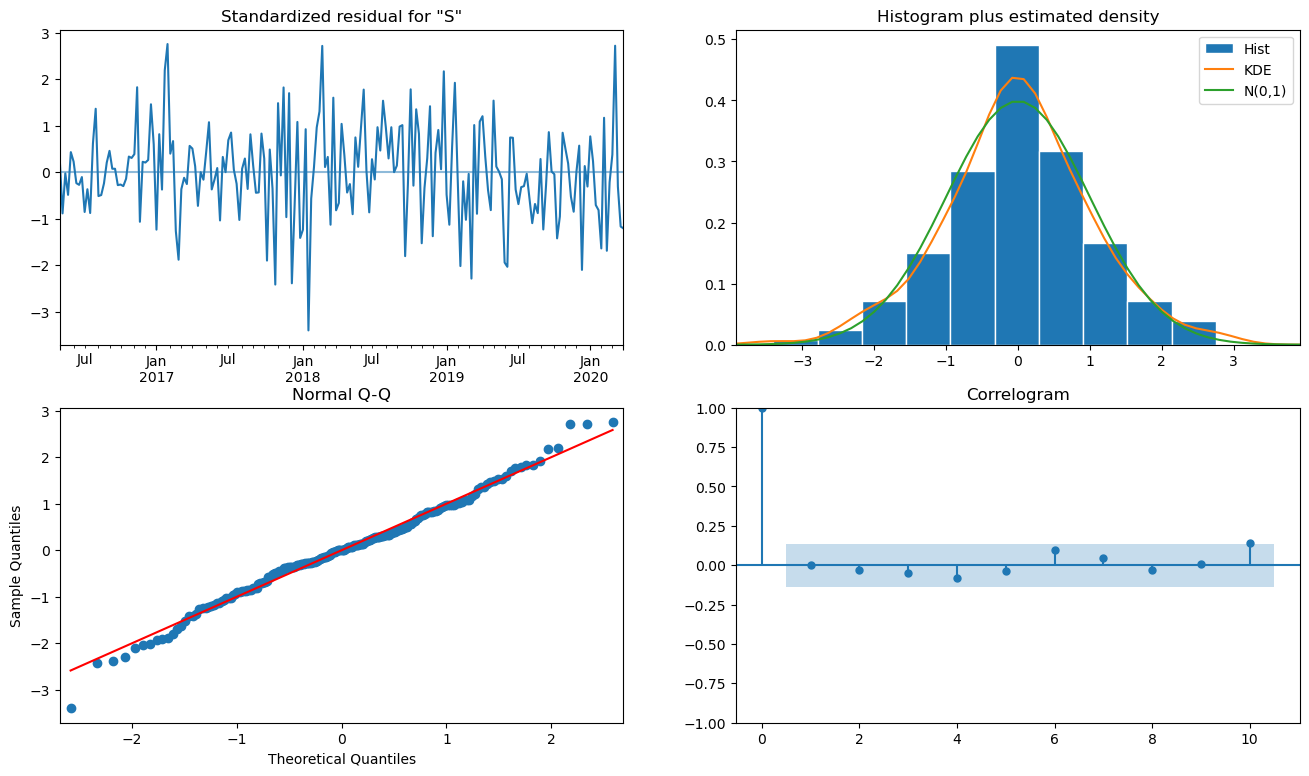

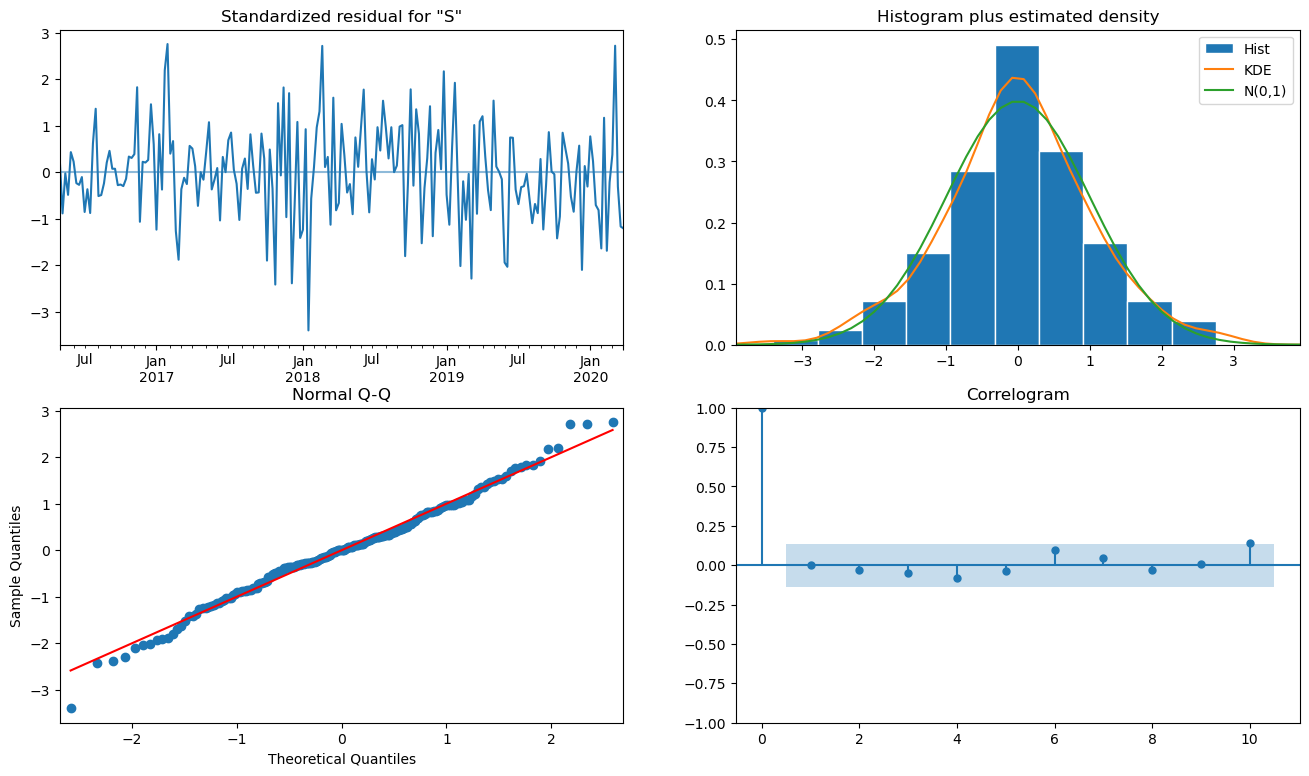

In [18]:
model_fit.plot_diagnostics(figsize=(16,9))

In [19]:
predictions_SARIMAX = model_fit.predict(start=0, end=len(train)+len(test)-1)

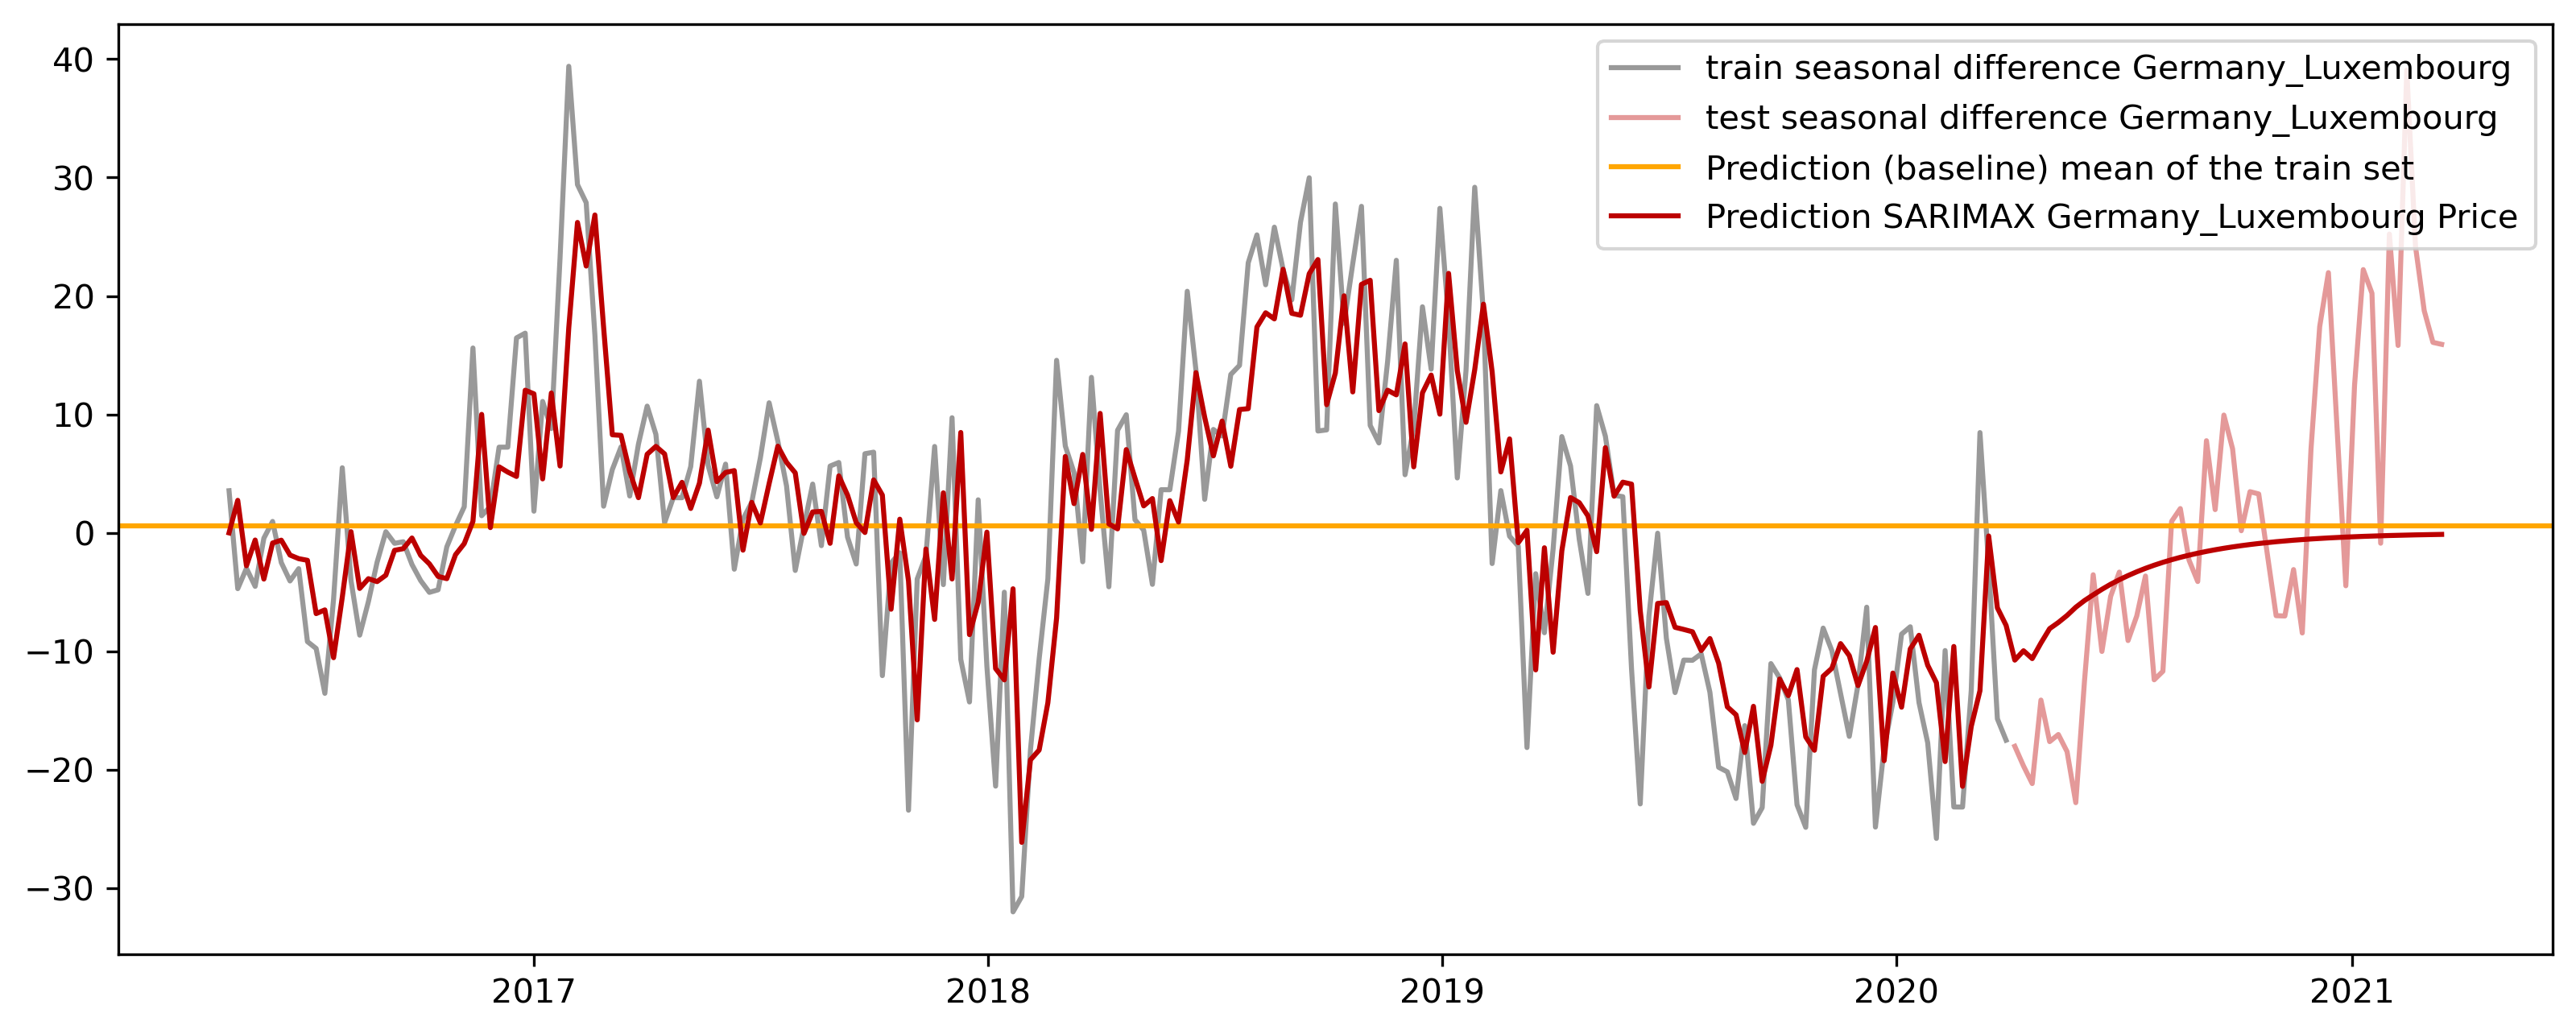

In [20]:
plt.figure(figsize= (13,5), dpi = 300)


plt.plot(train['Seasonal_difference_adjusted'], label = 'train seasonal difference Germany_Luxembourg ', color = '#000000', alpha = 0.4)
plt.plot(test['Seasonal_difference_adjusted'], label = 'test seasonal difference Germany_Luxembourg', color = '#bc0000', alpha =.4)
plt.axhline(y= train['Seasonal_difference_adjusted'].mean(),xmax=0, xmin=100, label = 'Prediction (baseline) mean of the train set', color= '#ffa600')
plt.plot(predictions_SARIMAX, label = 'Prediction SARIMAX Germany_Luxembourg Price', color = '#bc0000')

plt.legend()
plt.show()

In [21]:
#TODO: why is the performance of the SARIMAX-model so bad?

train_mape_SARIMAX = mean_absolute_percentage_error(train['Seasonal_difference_adjusted'], predictions_SARIMAX[train_series.index])
test_mape_SARIMAX = mean_absolute_percentage_error(test['Seasonal_difference_adjusted'], predictions_SARIMAX[test_series.index])


print(f"Train MAPE on the difference: {round(train_mape, 2)}%")
print(f"Test MAPE on the difference: {round(test_mape, 2)}%")
print(f"Train MAPE SARIMAX on the difference: {round(train_mape_SARIMAX, 2)}%")
print(f"Test MAPE SARIMAX on the difference: {round(test_mape_SARIMAX, 2)}%")

Train MAPE on the difference: 117.94%
Test MAPE on the difference: 104.6%
Train MAPE SARIMAX on the difference: 263.89%
Test MAPE SARIMAX on the difference: 99.28%


### Reconstruction


In [22]:
# we slice out the first 52 weeks and the rest of the dates
first_year_indices = Prices_GER_weekly_date_range_1.index[:52]
remaining_indices = Prices_GER_weekly_date_range_1.index[52:]



In [23]:
# create an empty restored column
Prices_GER_weekly_date_range_1['reconstructed'] = np.nan

# fill in the first 52 weeek values into the empty restored column
Prices_GER_weekly_date_range_1.loc[first_year_indices, 'reconstructed'] = Prices_GER_weekly_date_range_1.loc[first_year_indices, 'Germany_Luxembourg_adjusted']
# use the current difference value and 52-week lagged restored value to get the next restored value
for current_date in remaining_indices:
    current_value = Prices_GER_weekly_date_range_1.loc[current_date, 'Seasonal_difference_adjusted']

    year_before_restored = Prices_GER_weekly_date_range_1.loc[current_date - pd.DateOffset(weeks=52), 'reconstructed']

    Prices_GER_weekly_date_range_1.loc[current_date, 'reconstructed'] = year_before_restored + current_value


In [24]:

# check agreement everywhere (rounding errors can come up so check closeness rather than strict equality)
np.allclose(Prices_GER_weekly_date_range_1['Germany_Luxembourg_adjusted'], Prices_GER_weekly_date_range_1['reconstructed'])

True

In [25]:
# use the original train diff values and predicted test values
Prices_GER_weekly_date_range_1.loc[train.index, "AR_difference"] = Prices_GER_weekly_date_range_1.loc[train.index, 'Seasonal_difference_adjusted']
Prices_GER_weekly_date_range_1.loc[test.index, "AR_difference"] = predictions[test_series.index]


In [26]:
#TODO: why is it above the model? 
Prices_GER_weekly_date_range_1['AR_restored'] = np.nan

# fill in the first 12 original values into the empty restored column
Prices_GER_weekly_date_range_1.loc[first_year_indices, 'AR_restored'] = Prices_GER_weekly_date_range_1.loc[first_year_indices, 'Germany_Luxembourg_adjusted']

# use the current difference value and 12-month lagged restored value to get the next restored value
for current_date in remaining_indices:
    current_value = Prices_GER_weekly_date_range_1.loc[current_date, 'AR_difference']
    year_before_restored = Prices_GER_weekly_date_range_1.loc[current_date - pd.DateOffset(weeks=52), 'AR_restored']

    ## pd.DataOffset Question for Miranda
    
    Prices_GER_weekly_date_range_1.loc[current_date, 'AR_restored'] = year_before_restored + current_value



In [27]:
train = Prices_GER_weekly_date_range_1[['Seasonal_difference_adjusted']].loc[Prices_GER_weekly_date_range_1.index <= "2020-04-01"].dropna()
test = Prices_GER_weekly_date_range_1[['Seasonal_difference_adjusted']].loc[Prices_GER_weekly_date_range_1.index > "2020-04-01"]

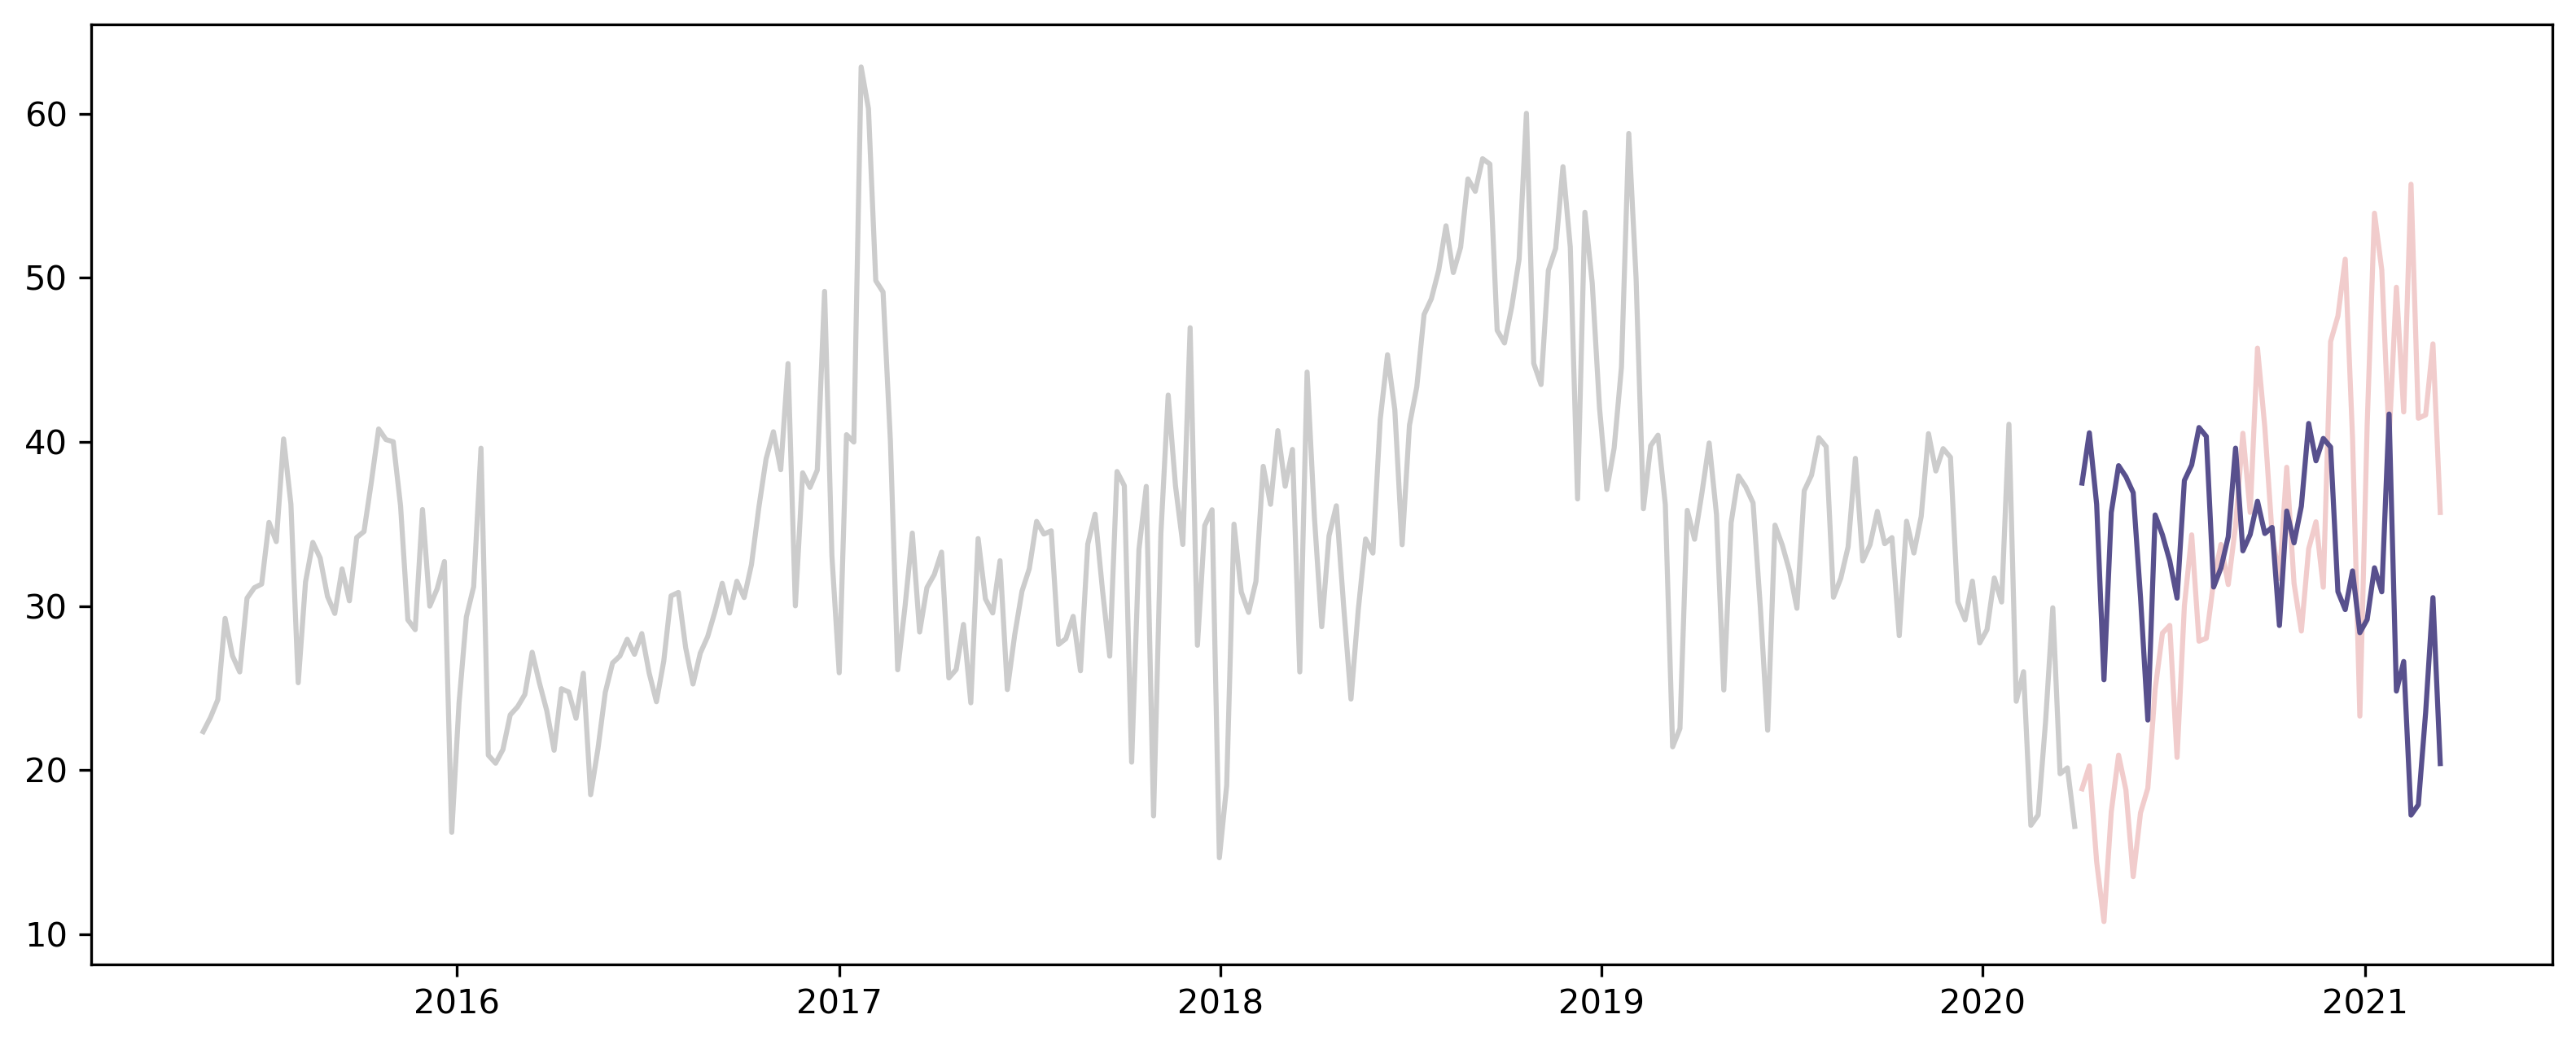

In [32]:
plt.figure(figsize= (13,5), dpi = 300)


plt.plot(Prices_GER_weekly_date_range_1.loc[Prices_GER_weekly_date_range_1.index <= '2020-04-01','Germany_Luxembourg_adjusted'], label = 'train Germany_Luxembourg ', color = '#000000', alpha = 0.2)
plt.plot(Prices_GER_weekly_date_range_1.loc[Prices_GER_weekly_date_range_1.index > '2020-04-01','Germany_Luxembourg_adjusted'], label = 'test Germany_Luxembourg', color = '#bc0000', alpha =.2)

#plt.plot(predictions_SARIMAX, label = 'Prediction SARIMAX Germany_Luxembourg Price', color = '#bc0000')
plt.plot(Prices_GER_weekly_date_range_1.loc[test.index, 'AR_restored'], label = 'Restored Germany_Luxembourg Price', color = '#58508d')
plt.plot(Prices_GER_weekly_date_range_1.loc[train.index, 'AR_restored'], label = 'Restored Germany_Luxembourg Price', color = '#ffa600', alpha =0.5)

plt.legend()
plt.show()

In [29]:
train_mape_RESTORED = mean_absolute_percentage_error(Prices_GER_weekly_date_range_1['Germany_Luxembourg_adjusted'], Prices_GER_weekly_date_range_1.loc[train.index, 'AR_restored'])
test_mape_RESTORED = mean_absolute_percentage_error(test_series, Prices_GER_weekly_date_range_1.loc[test.index, 'AR_restored'])


print(f"Train MAPE on the difference: {round(train_mape, 2)}%")
print(f"Test MAPE on the difference: {round(test_mape, 2)}%")

print('------------------------------------------------------------------------------')

print(f"Train MAPE SARIMAX on the difference: {round(train_mape_SARIMAX, 2)}%")
print(f"Test MAPE SARIMAX on the difference: {round(test_mape_SARIMAX, 2)}%")

print('------------------------------------------------------------------------------')

print(f"Train MAPE RESTORED on the difference: {round(train_mape_RESTORED, 2)}%")
print(f"Test MAPE RESTORED on the difference: {round(test_mape_RESTORED, 2)}%")

Train MAPE on the difference: 117.94%
Test MAPE on the difference: 104.6%
------------------------------------------------------------------------------
Train MAPE SARIMAX on the difference: 263.89%
Test MAPE SARIMAX on the difference: 99.28%
------------------------------------------------------------------------------
Train MAPE RESTORED on the difference: 0.0%
Test MAPE RESTORED on the difference: 1023.29%
